In [2]:
from kinpred.dataset import df_to_molentry_list, KinPredDataLoader, split_mollist_to_target
from kinpred.model import Encoder, Decoder, Discriminator, KinaseRegressionModel, freeze_module, unfreeze_module, KinaseProbRegressionModel
from kinpred.layers import MLPBlock
from kinpred.utils import AverageMeter


import itertools
from matplotlib import pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchsummary import summary

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr


In [3]:
# Read in the data 
df = pd.read_csv("kinase_JAK.csv")
df.head()

,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2


In [4]:
# convert the datagframe into a list of MolEntry objects and get all the targets in the dataset
mol_list, targets = df_to_molentry_list(df)

In [5]:
## Pre-Load all MolEntry Objects using multiprocessing

from concurrent.futures import ThreadPoolExecutor, as_completed

def load_molentry(entry):
    entry.to_fp()
    return True

with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(load_molentry, entry) for entry in mol_list]
    for _ in tqdm(as_completed(futures), total=len(futures)):
        pass

100%|██████████| 4528/4528 [00:45<00:00, 100.32it/s]


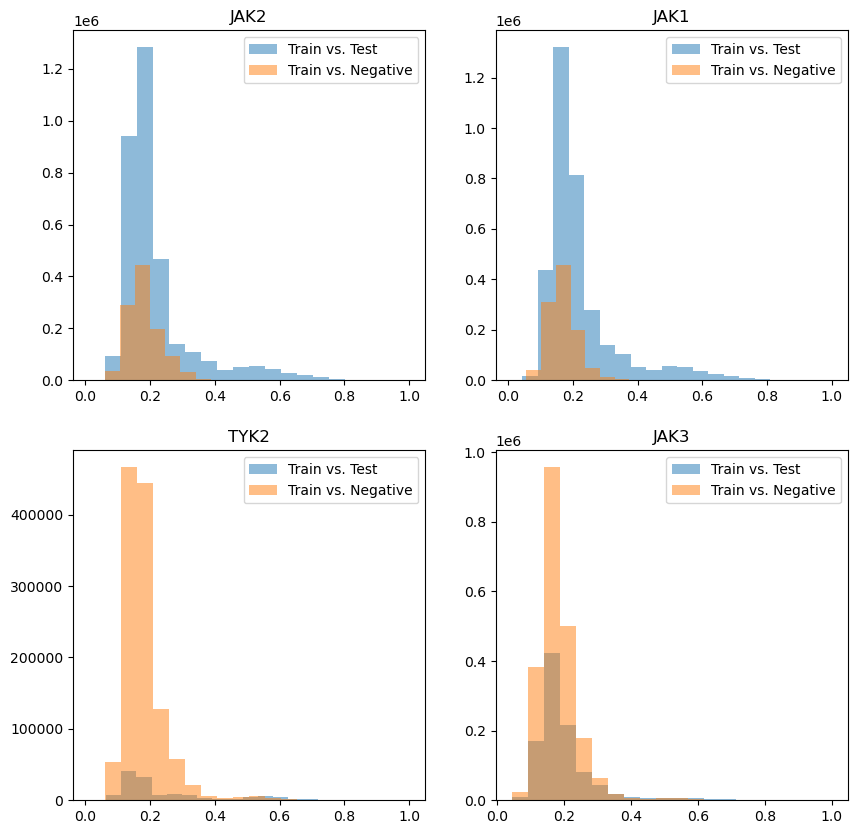

In [9]:
## Examine the Tanimotot similarity between the train and test set vs. the train and negative set for each of the 4 targets

plt.figure(figsize=(10, 10))

for i, target in enumerate(targets):
    train, test, negative_train, negative_test = split_mollist_to_target(mol_list, target, test_size=0.35, include_negatives=True)

    # Calculate the Tanimoto similarity between the groups
    train_fps = [mol.to_fp(as_bits=True) for mol in train]
    test_fps = [mol.to_fp(as_bits=True) for mol in test]
    neg_fps = [mol.to_fp(as_bits=True) for mol in negative_train]

    train_test_sim = [DataStructs.FingerprintSimilarity(train_fp, test_fp) for test_fp in test_fps for train_fp in train_fps]

    train_neg_sim = [DataStructs.FingerprintSimilarity(train_fp, neg_fp) for neg_fp in neg_fps for train_fp in train_fps]

    plt.subplot(2, 2, i+1)
    plt.hist(train_test_sim, bins=20, alpha=0.5, label="Train vs. Test")
    plt.hist(train_neg_sim, bins=20, alpha=0.5, label="Train vs. Negative")
    plt.title(target)
    plt.legend()
    
plt.show()


There is a relatively low amount of overlap between binders and non-binders. This shows that the Morgan Fingerprint bit-vector is a good representation to use as a learnable feature. Common neural nets that operate on [1,N] dimensional vectors have been well studied and are readily available: LightGBM and XGBoost to name a couple. Their performance is unparalleled for tabular data, but our underlying datastructure is not tabular, and holds more information than can be extracted from tabular features alone. This points directly to using graph neural networks as they are one of the best model choices for representing molecular structures, however, for a relatively small problem set such as this, can a feedforward network work just as well? 

Feedforward models are extremely versitile as we will see. They can be tailored for classification or regression (both with probabilitic outputs as well) with minimal model complexity. But there in lies the achilles heel, the simplicity of the model constrains which problems it can tackle. In our problem we have 4 targets with multiclass labels since each molecule is not constrained to one target alone. Predicting a single output value with confidence scores would be the simpliest but it would require 4 separate models. Lets entertain this idea and explore if we can make a small and accurate enough model to justify having 4 of them. 

I will be using a simple adversarial autoencoder to constrain embeddings to be closer together for binders and further apart for non-binders. The reason I chose this approach is because we have a small, well-defined set of targets and I am trying to keep the model as interpretable as possible. To that end I will use a simple two-phase model construction to verify the separation in the latent space within the encoder. The first phase is an Adversarial AutoEncoder and the second phase is a mixture-of-gaussians based MLP model. Naturally, the encoder will learn to amplify the properties of binders and dampen the properties of non-binders, and after training, we can discard the decoder completely. The encoder will then be used as a feature extractor for our MLP model and the disciminator's embedding layer as the start of the a probability estimator. Using a 2-part model such as this will hopefully allow the model's natural probabilistic tendencies to illuminate non-binders as having a high degree of uncertainty.   



In [7]:
# Set Target and split the data into train and test sets
target = "JAK1"
train, test, negative_train, negative_test = split_mollist_to_target(mol_list, target, test_size=0.35, include_negatives=True)

# Set key size and latent dimension
key_size, latent_dim = 1024, 256
# Set device as Mac GPU 
device = "mps"

train_dataloader = KinPredDataLoader(train, batch_size=64, shuffle=True, num_workers=0, target=target, device=device)
test_dataloader = KinPredDataLoader(test, batch_size=64, shuffle=True, num_workers=0, target=target, device=device)
negatives_dataloader = KinPredDataLoader(negative_train, batch_size=64, shuffle=True, num_workers=0, target="decoy", device=device)

In [33]:
# define model
# 1) generator (encoder + decoder)
encoder = Encoder(key_size, latent_dim)
decoder = Decoder(key_size, latent_dim, norm=nn.BatchNorm1d)
# 2) discriminator
discriminator = Discriminator(latent_dim, norm=nn.BatchNorm1d)

# loss functions 
# Embedding constraint loss 
adversarial_loss = nn.BCEWithLogitsLoss()
# Reconstruction loss
reconstruction_loss = nn.MSELoss()

# optimizers
optimizer_G = torch.optim.Adam(itertools.chain(encoder.parameters(), decoder.parameters()), 
                                lr=0.001, betas=(0.8, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), 
                                lr=0.001, betas=(0.8, 0.999))

# Learning Rate Scheduler, cyclic learning rate
lr_scheduler_G = torch.optim.lr_scheduler.CyclicLR(optimizer_G, base_lr=0.0001, max_lr=0.005, step_size_up=25, step_size_down=5, mode="triangular2", cycle_momentum=False)
lr_scheduler_D = torch.optim.lr_scheduler.CyclicLR(optimizer_D, base_lr=0.0001, max_lr=0.005, step_size_up=25, step_size_down=5, mode="triangular2", cycle_momentum=False)


In [21]:
# Move all models and loss functions to defined device 
encoder.to(device)
decoder.to(device)
discriminator.to(device)
adversarial_loss.to(device)
reconstruction_loss.to(device)

MSELoss()

In [34]:
# Cache negative fingerprints for faster sampling
NEGATIVE_FP = np.array([neg.to_fp() for neg in negative_train])

# Sample negative fingerprints of size batch_size for adversarial training
def sample_negative(batch_size):
    batch = NEGATIVE_FP[np.random.choice(len(NEGATIVE_FP), replace=False, size=batch_size)]
    if device == "cpu":
        return torch.from_numpy(batch)
    elif device == "mps":
        return torch.from_numpy(batch).float().to(device)
    else:
        return torch.from_numpy(batch).to(device)


In [ ]:
# training phase
encoder.train()
decoder.train()
discriminator.train()

for epoch in range(150):
    train_iter = iter(train_dataloader)
    for _ in range(len(train_dataloader)):
        features, _ = next(train_iter) 
        negative_sample = sample_negative(features.shape[0])
        # 1) reconstruction + generator loss
        valid = torch.ones(features.shape[0], 1).to(device)
        fake = torch.zeros(features.shape[0], 1).to(device)

        optimizer_G.zero_grad()
        latent_z = encoder(features)
        decoded_x = decoder(latent_z)
        validity_fake_z = discriminator(latent_z)

        advl_G = adversarial_loss(validity_fake_z, valid)
        recon_G = reconstruction_loss(decoded_x, features)
        G_loss = 0.05*advl_G + 0.95*recon_G
        G_loss.backward(retain_graph=True)
        optimizer_G.step()
        
        lr_scheduler_G.step()
        
        # 2) discriminator loss
        optimizer_D.zero_grad()
        fake_z = encoder(negative_sample)
        real_loss = adversarial_loss(discriminator(latent_z.detach()), valid)
        fake_loss = adversarial_loss(discriminator(fake_z), fake)
        D_loss = 0.5*(real_loss + fake_loss)
        D_loss.backward(retain_graph=True)
        optimizer_D.step()
        
        lr_scheduler_D.step()

    # print loss
    print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] --> [real loss: %.3f] [fake loss: %.3f]" 
            % (epoch, 150, G_loss.item(), D_loss.item(), real_loss.item(), fake_loss.item()))

In [ ]:
# Save the weights of the encoder, decoder and discriminator
# torch.save(encoder.state_dict(), f"kinpred/weights/MLP/encoder_{target}.pth")
# torch.save(decoder.state_dict(), f"kinpred/weights/MLP/decoder_{target}.pth")
# torch.save(discriminator.state_dict(), f"kinpred/weights/MLP/discriminator_{target}.pth")

## Examine The Encoder Features and the Discriminator Accuracy 

In [23]:
encoder.load_state_dict(torch.load(f"kinpred/weights/MLP/encoder_{target}.pth"))
decoder.load_state_dict(torch.load(f"kinpred/weights/MLP/decoder_{target}.pth"))
discriminator.load_state_dict(torch.load(f"kinpred/weights/MLP/discriminator_{target}.pth"))

<All keys matched successfully>

### How well can the Discriminator separate actives from nonactives? 

In [24]:
encoder.eval()
discriminator.eval()

Discriminator(
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=64, out_features=32, bias=True)
  (norm4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=32, out_features=1, bias=True)
)

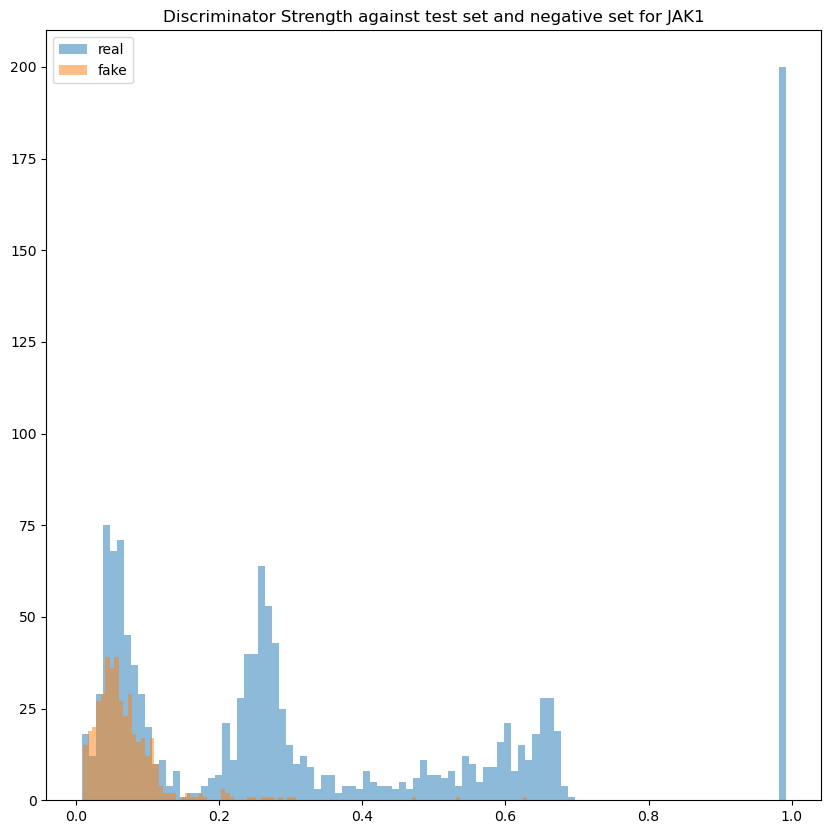

In [27]:
## Evaluate Discriminator strength

latent_real_vals = []
latent_fake_vals = []

with torch.no_grad():
    for i in test_dataloader:
        (features, _) = i
        latent_z = encoder(features)
        real_values = torch.sigmoid(discriminator(latent_z))
        latent_real_vals.extend(real_values.detach().cpu().numpy().flatten())
    for i in negatives_dataloader:
        (features, _) = i
        latent_z = encoder(features)
        fake_values = torch.sigmoid(discriminator(latent_z))
        latent_fake_vals.extend(fake_values.detach().cpu().numpy().flatten())

#plot fake vs real 
plt.figure(figsize=(10,10))
plt.title("Discriminator Strength against test set and negative set for JAK1")
plt.hist(latent_real_vals, bins=100, alpha=0.5, label="real")
plt.hist(latent_fake_vals, bins=100, alpha=0.5, label="fake")
plt.legend()
plt.show()


Woah! It looks like the discriminator can find a large boundary between the latent features of the actives vs inactives. Now, lets examine how the encoder separates binders from non-binders in the latent space.

/Users/corykornowicz/opt/miniforge/envs/mfep/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/corykornowicz/opt/miniforge/envs/mfep/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


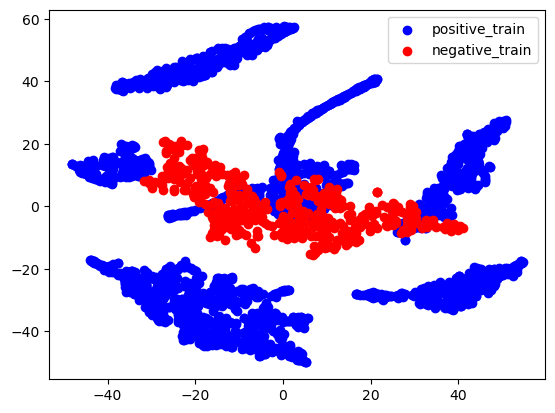

In [26]:
## Calculate tSNE on the emebeddings and plot the results on a scatter plot 

#Calculate the embeddings for the training set and negative training set  
train_embeddings = [encoder(batch[0]).cpu().detach().numpy() for batch in train_dataloader]
negative_embeddings_train = [encoder(batch[0]).cpu().detach().numpy() for batch in negatives_dataloader]

train_embeddings = np.concatenate(train_embeddings)
negative_embeddings_train = np.concatenate(negative_embeddings_train)

# perform tSNE on the embeddings and project to a 2D plane
train_tsne = TSNE(n_components=2,init="pca", metric="euclidean",learning_rate="auto").fit_transform(train_embeddings)
negative_train_tsne = TSNE(n_components=2,init="pca", metric="euclidean",learning_rate="auto").fit_transform(negative_embeddings_train)

plt.scatter(train_tsne[:,0], train_tsne[:,1], label="positive_train", c="blue")
plt.scatter(negative_train_tsne[:,0], negative_train_tsne[:,1], label="negative_train", c="red")
plt.legend()
plt.show()

There is some overlap, but a majority of positive clusters are separated from the negative cluster. This is a good sign that the model is learning to separate the two classes. Lets see how well this translates to the MLP model's regressive abilities.

In [8]:
# Load up dataloaders 
train_loader = KinPredDataLoader(train, batch_size=32, shuffle=True, num_workers=0, target=target, device=device)
test_loader = KinPredDataLoader(test, batch_size=32, shuffle=True, num_workers=0, target=target, device=device)
negative_train_loader = KinPredDataLoader(negative_train, batch_size=32, shuffle=True, num_workers=0, target="decoy", device=device)
negative_test_loader = KinPredDataLoader(negative_test, batch_size=32, shuffle=True, num_workers=0, target="decoy", device=device)

Before we jump into the Mixture of Gaussians model, lets examine if a simple MLP can learn to predict the binding affinity.

In [11]:
# Load the model and freeze the encoder and discriminator layers so they are not modified during training. Move the model to the GPU
model = KinaseRegressionModel(key_size, latent_dim, nn.SiLU())
model.encoder.load_state_dict(torch.load(f"kinpred/weights/MLP/encoder_{target}.pth"))
model.discriminator_layer.load_state_dict(torch.load(f"kinpred/weights/MLP/discriminator_{target}.pth"))
model.float().to(device)
freeze_module(model.encoder)
freeze_module(model.discriminator_layer)

In [12]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=0.001, max_lr=0.005, step_size_up=10, step_size_down=10, mode="triangular2", cycle_momentum=False)
mse_criterion = nn.MSELoss(reduction="mean")

In [ ]:
epochs = 100 
train_loss = AverageMeter()
test_loss = AverageMeter()

for j in range(epochs):
    model.train()
    for (features, labels) in train_loader:
        optim.zero_grad()
        output = model(features)
        loss = mse_criterion(output, labels)
        loss.backward()
        train_loss.update(loss.item(), 1)
        optim.step()
        lr_scheduler.step()
    with torch.no_grad():
        model.eval()
        for (features, labels) in test_loader:
            output = model(features)
            loss = mse_criterion(output, labels)
            test_loss.update(loss.item(), 1)
            
    print("Epoch: %d/%d, Train Loss: %.3f, Test Loss: %.3f" % (j, epochs, train_loss.avg, test_loss.avg))

R2: 0.326, Pearson: 0.588, MAE: 0.711


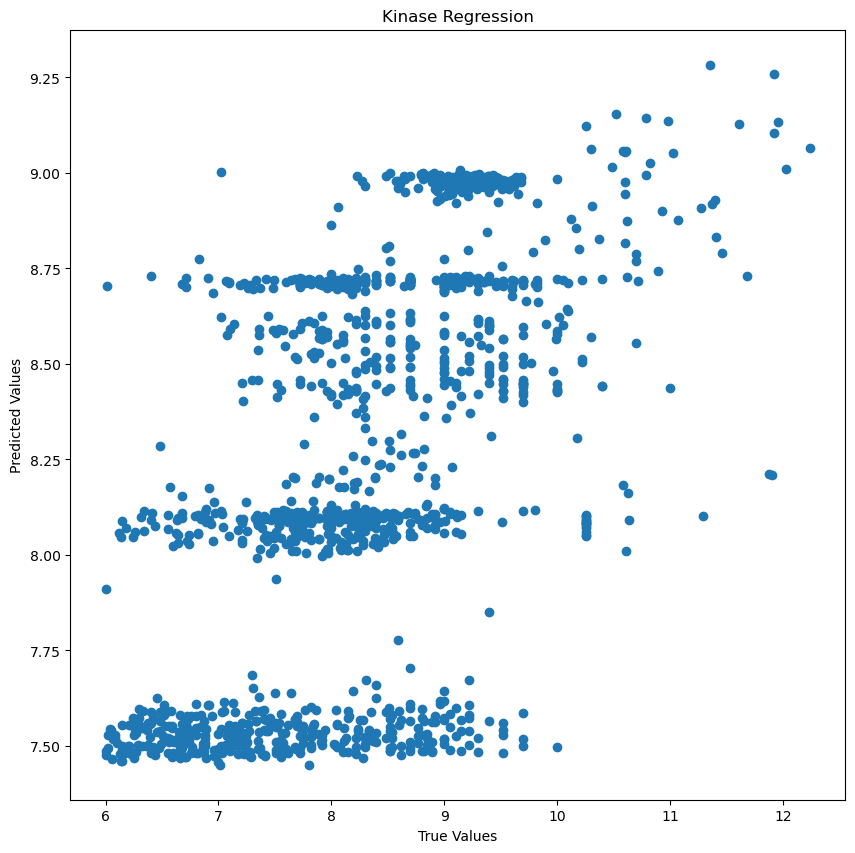

In [14]:
## Test Example 

scores = []
true_vals = []

with torch.no_grad():
    model.eval()
    for (batch, label) in test_loader:
        output = model(batch)
        scores.append(output.cpu().detach().numpy().flatten())
        true_vals.append(label.cpu().detach().numpy().flatten())

## Calculate r2, pearson, and MAE

scores = np.concatenate(scores)
true_vals = np.concatenate(true_vals)

r2 = r2_score(true_vals, scores)
pearson = pearsonr(true_vals, scores)
print("R2: %.3f, Pearson: %.3f, MAE: %.3f" % (r2, pearson[0], np.mean(np.abs(true_vals - scores))))

plt.figure(figsize=(10,10))
plt.title("Kinase Regression")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.scatter(true_vals, scores)
plt.show()



The performance is not great and scores often collapse near the highest represented values in the training set. Now, lets try the Mixture of Gaussians (MoG) model. This kind of model can be used to create a distribution parameterized on the input. While we don't necessarily need the distribution of pIC50 values, it allows us to understand the models condfidence based on the variance of the distribution and will hopefully allow the scores to spread out more.

In [40]:
model = KinaseProbRegressionModel(key_size, latent_dim, 3, nn.ReLU())
model.encoder.load_state_dict(torch.load(f"kinpred/weights/MLP/encoder_{target}.pth"))
model.discriminator_layer.load_state_dict(torch.load(f"kinpred/weights/MLP/discriminator_{target}.pth"))
model.float().to(device)
freeze_module(model.encoder)
freeze_module(model.discriminator_layer)

In [41]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.CyclicLR(optim, base_lr=0.001, max_lr=0.005, step_size_up=10, step_size_down=10, mode="triangular2", cycle_momentum=False)

In [ ]:
epochs = 150 
train_loss = AverageMeter()
test_loss = AverageMeter()

for j in range(epochs):
    model.train()
    for (features, labels) in train_loader:
        optim.zero_grad()
        pi, mu, sigma = model(features)
        loss = model.calculate_loss(pi, mu, sigma, labels)
        loss.backward()
        train_loss.update(loss.item(), 1)
        optim.step()
        lr_scheduler.step()
    with torch.no_grad():
        model.eval()
        for (features, labels) in test_loader:
            pi, mu, sigma = model(features)
            loss = model.calculate_loss(pi, mu, sigma, labels)
            test_loss.update(loss.item(), 1)
            
    print("Epoch: %d/%d, Train Loss: %.3f, Test Loss: %.3f" % (j, epochs, train_loss.avg, test_loss.avg))

In [51]:
# save the model's weights
torch.save(model.state_dict(), f"kinpred/weights/MLP/kinpred_model_{target}.pth")

R2: 0.283, Pearson: 0.544, MAE: 0.714


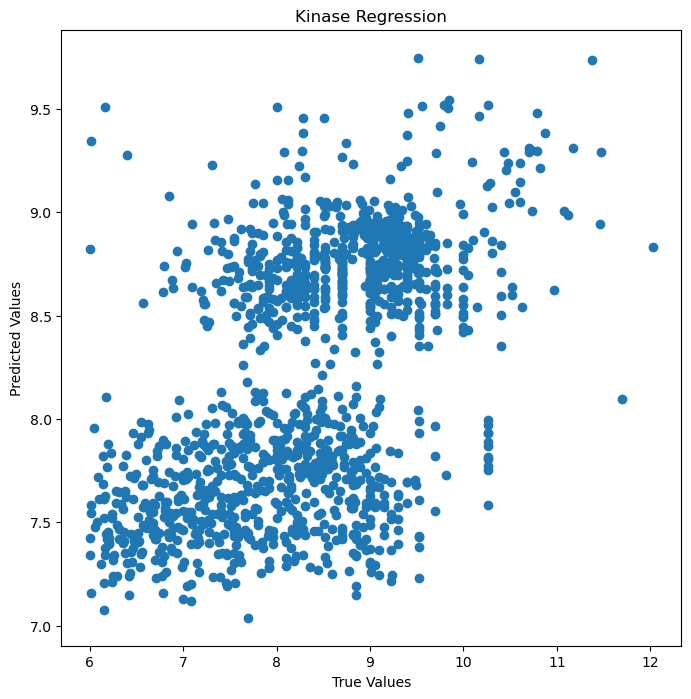

In [44]:
## Calculate r2, pearson, and MAE
scores = []
true_vals = []

with torch.no_grad():
    model.eval()
    for (batch, label) in test_loader:
        pi, mu, sigma = model(batch)
        output = model.generate_point_predictions(pi, sigma, mu, n_samples=50)
        scores.append(output.cpu().detach().numpy().flatten())
        true_vals.append(label.cpu().detach().numpy().flatten())


scores = np.concatenate(scores)
true_vals = np.concatenate(true_vals)

r2 = r2_score(true_vals, scores)
pearson = pearsonr(true_vals, scores)
print("R2: %.3f, Pearson: %.3f, MAE: %.3f" % (r2, pearson[0], np.mean(np.abs(true_vals - scores))))

plt.figure(figsize=(8,8))
plt.title("Kinase Regression")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.scatter(true_vals, scores)
plt.show()



Analyze the MoG model's distribution of pi, mu, and sigma against the binders and non-binders.

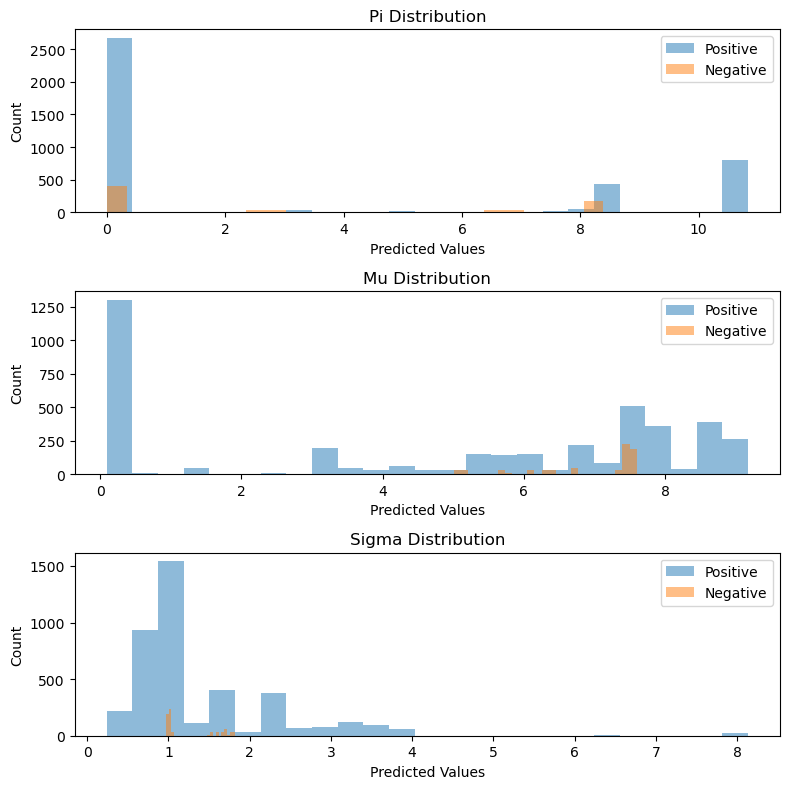

In [54]:
pos_pi = []
neg_pi = []

pos_mu = []
neg_mu = []

pos_sigma = []
neg_sigma = []

# argmax of pi is the most likely score

with torch.no_grad():
    model.eval()
    for (batch, label) in test_loader:
        pi, mu, sigma = model(batch)
        idx = torch.argmax(pi, dim=1)
        pos_pi.append(pi[idx].cpu().detach().numpy().flatten())
        pos_mu.append(mu[idx].cpu().detach().numpy().flatten())
        pos_sigma.append(sigma[idx].cpu().detach().numpy().flatten())

with torch.no_grad():
    model.eval()
    for (batch, label) in negative_test_loader:
        pi, mu, sigma = model(batch)
        idx = torch.argmax(pi, dim=1)
        neg_pi.append(pi[idx].cpu().detach().numpy().flatten())
        neg_mu.append(mu[idx].cpu().detach().numpy().flatten())
        neg_sigma.append(sigma[idx].cpu().detach().numpy().flatten())


pos_pi = np.concatenate(pos_pi)
neg_pi = np.concatenate(neg_pi)

pos_mu = np.concatenate(pos_mu)
neg_mu = np.concatenate(neg_mu)

neg_sigma = np.concatenate(neg_sigma)
pos_sigma = np.concatenate(pos_sigma)

plt.figure(figsize=(8,8))
plt.subplot(3, 1, 1)
plt.title("Pi Distribution")
plt.xlabel("Predicted Values")
plt.ylabel("Count")
plt.hist(pos_pi, bins=25, alpha=0.5, label="Positive")
plt.hist(neg_pi, bins=25, alpha=0.5, label="Negative")
plt.legend()

plt.subplot(3, 1, 2)
plt.title("Mu Distribution")
plt.xlabel("Predicted Values")
plt.ylabel("Count")
plt.hist(pos_mu, bins=25, alpha=0.5, label="Positive")
plt.hist(neg_mu, bins=25, alpha=0.5, label="Negative")
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Sigma Distribution")
plt.xlabel("Predicted Values")
plt.ylabel("Count")
plt.hist(pos_sigma, bins=25, alpha=0.5, label="Positive")
plt.hist(neg_sigma, bins=25, alpha=0.5, label="Negative")
plt.legend()

plt.tight_layout()
plt.show()
   

Without training explicitly on the negative samples, the model has learned to give non-binders a higher predicted deviation and a lower predicted mean. While it is learning to be more confident in its predictions, it did not achieve as high of an accuracy as the vanialla MLP did. This model also does not solve the issue of predicting against all 4 targets at once.

A few key takes aways from this section:
* The adversarial autoencoder is a good way to constrain the encoder to learn to separate binders from non-binders.
* The vanilla MLP model suffers from collapsing scores, and while the MoG model does allow more variation in predictions, it does not increase the overall accuracy.
* This path needs 4 separate models, and while they are lightweight, it creates unnecessary complexity and overhead.

I chose to tackle the aforementioned issues using a Graph Neural Network that integrates 3D pharmacophoric features and morgan fingerprints. The former being to identifiy key components of each molecule per target and the latter being to inject latent encodings into the compressed graph features. While I could have chosen to disregard the fingerprints and focus entirely on using the node/edge features, I knew they provide a good indication of whether a molecule was a binder vs. a non-binder from the earlier fingerprint analysis.

_Continued in GNN_Training.ipynb_
    
